Manufacturing AI Agent

- Install Dependencies
  
```bash 
pipenv shell
pipenv install langgraph langchain  
pipenv install langchain-google-genai==2.1.5 
pipenv google-ai-generativelanguage==0.6.18

// check the version
python3 -m langchain_core.sys_info

```

- Run the project
```bash
pipenv shell
pipenv --venv

```

Get the kernel name and select that for the jupyter notebook

In [3]:
import os
import json
from langgraph.graph import StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage 
# from langchain.memory import ConversationBufferWindowMemory

/home/ozkary/.local/share/virtualenvs/chat-gpt-2H0-IQSn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
!python3 -m langchain_core.sys_info


System Information
------------------
> OS:  Linux
> OS Version:  #1 SMP PREEMPT_DYNAMIC Thu Jun  5 18:30:46 UTC 2025
> Python Version:  3.9.5 (default, Nov 23 2021, 15:27:38) 
[GCC 9.3.0]

Package Information
-------------------
> langchain_core: 0.3.66
> langchain: 0.3.26
> langsmith: 0.4.1
> langchain_google_genai: 2.0.10
> langchain_text_splitters: 0.3.8
> langgraph_sdk: 0.1.70

Optional packages not installed
-------------------------------
> langserve

Other Dependencies
------------------
> async-timeout<5.0.0,>=4.0.0;: Installed. No version info available.
> filetype: 1.2.0
> google-generativeai: 0.8.5
> httpx: 0.28.1
> httpx>=0.25.2: Installed. No version info available.
> jsonpatch<2.0,>=1.33: Installed. No version info available.
> langchain-anthropic;: Installed. No version info available.
> langchain-aws;: Installed. No version info available.
> langchain-azure-ai;: Installed. No version info available.
> langchain-cohere;: Installed. No version info available.
> langchai

In [4]:
# --- Setup ---
GEMINI_KEY = os.getenv("GEMINI_KEY")
# print(GEMINI_KEY)

# Initialize Gemini LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.3,  # .1-.3 more deterministic
    google_api_key=GEMINI_KEY
)

In [5]:

# --- System Prompt ---
SYSTEM_PROMPT = """
You are a specialized control chart monitoring agent in a manufacturing environment.
Your job is to assess whether a process is trending out of control based on sensor readings and SPC rules.
Ignore the thought element.

Use this format:
@observe: Acknowledge the new reading.
@reason: Explain trend status or SPC rule violations.
@act: Recommend an action (e.g., monitor, alert supervisor, prep shutdown).
"""

# --- Sample Input ---
sensor_data = {
    "sensor": "vibration_motor_3A",
    "timestamp": "2025-06-18T11:47:09Z",
    "value": 0.89,
    "unit": "mm/s",
    "ucl": 0.90,
    "lcl": 0.50,
    "trend_window": [0.91, 0.94, 0.86, 0.89],
    "alert_enabled": True
}

## 🔁 LangGraph Agent Workflow

This section explains how LangGraph is used to define and orchestrate an AI agent pipeline. The agent performs a structured SPC (Statistical Process Control) analysis over sensor data using a modular and reactive graph-based system.

---

### 🧩 Node Definitions

Each function below is defined as a **LangGraph node**, which receives and returns state (a dictionary) to carry data through the workflow.

- **`ingest(state)`**  
  Extracts and standardizes the input under the key `"sensor_data"`.

- **`analyze(state)`**  
  Formats the sensor data and passes it as a prompt to the LLM (`llm.invoke(...)`). It stores a record of input/output in memory, and outputs the LLM’s structured response (e.g., `@observe`, `@reason`, `@act`).

- **`output(state)`**  
  Displays the response to the terminal. It serves as the terminal node in the graph.

---

### 🧠 Graph Construction

Using `StateGraph`, the following steps are taken to build and compile the agent:

```mermaid
graph TD
  Start([Start])
  Ingest([🟢 ingest<br>Receive and pass sensor data])
  Analyze([🧠 analyze<br>Format data, invoke LLM, store response])
  Output([📤 output<br>Display agent response])
  End([🏁 END])

  Start --> Ingest
  Ingest --> Analyze
  Analyze --> Output
  Output --> End

```


In [6]:
from IPython.display import display, Markdown
def display_agent_response(response): 
    print("===== 🤖 AI AGENT RESPONSE =====\n")
    try:
        # Convert string to dictionary
        response_dict = json.loads(response)           
        print(f"\n📡 @observe:\n{response_dict.get('@observe', 'N/A')}")
        print(f"\n🧠 @reason:\n{response_dict.get('@reason', 'N/A')}")
        print(f"\n⚙️ @act:\n{response_dict.get('@act', 'N/A')}")
        print("\n" + "="*30)
    except Exception as e:
         display(Markdown(response))


In [7]:
from typing import TypedDict

class AgentStateSchema(TypedDict):
    input: dict
    sensor_data: dict
    response: str

graph = StateGraph(AgentStateSchema)

In [8]:
def ingest(state: AgentStateSchema):
    """
    Ingests initial input and sensor data into the state.
    """
    print("--- ⚙️ Ingesting Data ---")
    new_state = {
        "sensor_data": state.get("input", {}), # Assuming 'input' key from initial invoke is sensor_data
        "input": {} # Clear input after processing
    }
    print(f"Ingested Sensor Data: {new_state['sensor_data']}")
    return new_state

def analyze(state: AgentStateSchema):
    """
    Analyzes sensor data using the LLM and expects a JSON response.
    """
    print("--- ⚙️ Analyzing Data with LLM ---")
    sensor_data = state.get("sensor_data", {})

    # Construct the messages for Gemini, including the system prompt and user input
    messages = [
        SystemMessage(content=SYSTEM_PROMPT),
        HumanMessage(content=f"""
        Analyze the following sensor data and provide your assessment in the specified JSON format.
        
        Sensor Data: {json.dumps(sensor_data, indent=2)}
        """)
    ]

    # Invoke the LLM
    full_content = ""
    try:
        llm_response = llm.invoke(messages)
        full_content = llm_response.content     
        # full_content = json.loads(llm_response.content)
        print(f"LLM Raw Output:\n{full_content}")
    except Exception as e:
         print(f"Error: LLM did not return valid JSON. Error: {e}")

    # Store the full content as the response. It's expected to be a JSON string.
    new_state = {
        "response": full_content
    }

    return new_state

def output(state: AgentStateSchema):
    """
    Handles the final output, displaying the structured agent response.
    """
    print("--- ⚙️ Final Output Node ---")
    resp = state.get('response', '{}')
    display_agent_response(resp)
    return {} # No further state changes for the final node

In [9]:
# --- Build Graph ---
graph.add_node("ingest", ingest)
graph.add_node("analyze", analyze)
graph.add_node("output", output)

graph.set_entry_point("ingest")
graph.add_edge("ingest", "analyze")
graph.add_edge("analyze", "output")
graph.add_edge("output", END)


In [10]:
# --- Compile and Run ---
app = graph.compile()
app.invoke({"input": sensor_data})


--- ⚙️ Ingesting Data ---
Ingested Sensor Data: {'sensor': 'vibration_motor_3A', 'timestamp': '2025-06-18T11:47:09Z', 'value': 0.89, 'unit': 'mm/s', 'ucl': 0.9, 'lcl': 0.5, 'trend_window': [0.91, 0.94, 0.86, 0.89], 'alert_enabled': True}
--- ⚙️ Analyzing Data with LLM ---
LLM Raw Output:
@observe: New vibration reading received: 0.89 mm/s.
@reason: The current reading is within control limits (0.5 mm/s - 0.9 mm/s). However, the two previous readings in the trend window (0.94, 0.86) exceeded the current reading.
@act: Monitor the next reading closely for a continued downward trend.
--- ⚙️ Final Output Node ---
===== 🤖 AI AGENT RESPONSE =====



@observe: New vibration reading received: 0.89 mm/s.
@reason: The current reading is within control limits (0.5 mm/s - 0.9 mm/s). However, the two previous readings in the trend window (0.94, 0.86) exceeded the current reading.
@act: Monitor the next reading closely for a continued downward trend.

{'input': {},
 'sensor_data': {'sensor': 'vibration_motor_3A',
  'timestamp': '2025-06-18T11:47:09Z',
  'value': 0.89,
  'unit': 'mm/s',
  'ucl': 0.9,
  'lcl': 0.5,
  'trend_window': [0.91, 0.94, 0.86, 0.89],
  'alert_enabled': True},
 'response': '@observe: New vibration reading received: 0.89 mm/s.\n@reason: The current reading is within control limits (0.5 mm/s - 0.9 mm/s). However, the two previous readings in the trend window (0.94, 0.86) exceeded the current reading.\n@act: Monitor the next reading closely for a continued downward trend.'}

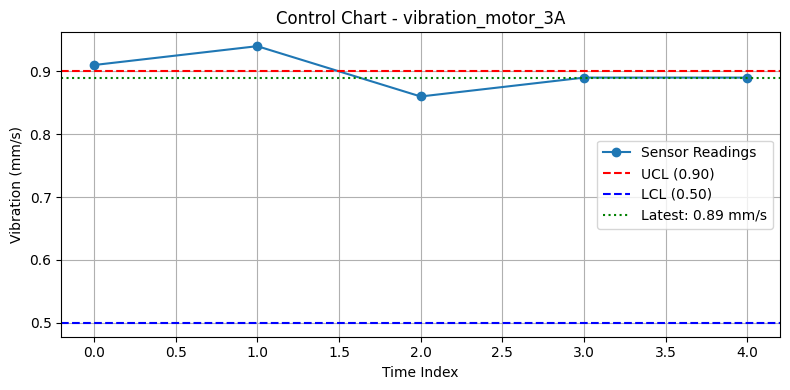

In [15]:
import plotly
import matplotlib.pyplot as plt

# Prepare the chart data
values = sensor_data["trend_window"] + [sensor_data["value"]]
timestamps = list(range(len(values)))  # simulate time steps

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(timestamps, values, marker='o', label="Sensor Readings")
plt.axhline(sensor_data["ucl"], color='red', linestyle='--', label="UCL (0.90)")
plt.axhline(sensor_data["lcl"], color='blue', linestyle='--', label="LCL (0.50)")
plt.axhline(sensor_data["value"], color='green', linestyle=':', label=f"Latest: {sensor_data['value']} mm/s")
plt.title(f"Control Chart - {sensor_data['sensor']}")
plt.xlabel("Time Index")
plt.ylabel(f"Vibration ({sensor_data['unit']})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
